# Example: Placement of Charging Stations

Determining optimal locations to build new electric vehicle charging stations is a complex optimization problem. Many factors should be taken into consideration, like existing charger locations, points of interest (POIs), quantity to build, etc. In this example, we take a look at how we might formulate this optimization problem and solve it using the Dynex Neuromorphic Platform.

## Problem Formulation

There are many different variations of the electric vehicle charger placement problem that might be considered. For this demo, we examine the case in which a small region is under consideration, and all locations in our area of consideration are within walking distance. In this situation, we want to place new charging locations that are convenient to all POIs. For example, if the POIs are shops on a main street it is most convenient to park once in a central location. We will satisfy this need by considering the average distance from a potential new charging location all POIs. Additionally, we want to place new chargers away from existing and other new charging locations so as to minimize overlap and maximize coverage of the region.

This problem can be considered as a set of 4 independent constraints (or objectives) with binary variables that represent each potential new charging station location.

## Minimize distance to POIs 

For each potential new charging station location, we compute the average distance to all POIs on the map. Using this value as a linear bias on each binary variable, our program will prefer locations that are (on average) close to the POIs. Note that this constraint could be replaced by an alternative one depending on the real world scenario for this problem.

## Maximize distance to existing charging stations 

For each potential new charging station location, we compute the average distance to all existing charging locations on the map. Using the negative of this value as a linear bias on each binary variable, our program will prefer locations that are (on average) far from existing chargers.

## Maximize distance to other new charging stations 

For the pair of new charging station locations, we would like to maximize the distance between them. To do this, we consider all possible pairs of locations and compute the distance between them. Using the negative of this value as a quadratic bias on the product of the corresponding binary variables, our program will prefer locations that are far apart.

## Build exactly two new charging stations 

To select exactly two new charging stations, we use dimod.generators.combinations. This function in dimod's package sets exactly num_new_cs of our binary variables (bqm.variables) to have a value of 1, and applies a strength to this constraint (gamma4). See below for more information on the tunable strength parameter.

## Parameter tuning 

Each of these constraints is built into our BQM object with a coefficient (names all start with gamma). This term gamma is known as a Lagrange parameter and can be used to weight the constraints against each other to accurately reflect the requirements of the problem. You may wish to adjust this parameter depending on your problem requirements and size. The value set here in this program was chosen to empirically work well as a starting point for problems of a wide-variety of sizes. 

# Implementation 

First, we load the required packages:

In [1]:
from itertools import product
import json
import random 
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import dynex
import dimod

We create a few helper functions to set up the scenario given the width and height of the grid as well as the number of points of intersts and existing number of charging stations:

In [2]:
def set_up_scenario(w, h, num_poi, num_cs):
    """Build scenario set up with specified parameters.
    
    Args:
        w (int): Width of grid
        h (int): Height of grid
        num_poi (int): Number of points of interest
        num_cs (int): Number of existing charging stations
    
    Returns:
        G (networkx graph): Grid graph of size w by h
        pois (list of tuples of ints): A fixed set of points of interest
        charging_stations (list of tuples of ints): 
            Set of current charging locations
        potential_new_cs_nodes (list of tuples of ints): 
            Potential new charging locations
    """

    G = nx.grid_2d_graph(w, h)
    nodes = list(G.nodes)

    # Identify a fixed set of points of interest
    pois = random.sample(nodes, k=num_poi)

    # Identify a fixed set of current charging locations
    charging_stations = random.sample(nodes, k=num_cs)

    # Identify potential new charging locations
    potential_new_cs_nodes = list(G.nodes() - charging_stations)

    return G, pois, charging_stations, potential_new_cs_nodes

The distance function returns the distance between two coordinates:

In [3]:
def distance(a, b):
    return (a[0]**2 - 2*a[0]*b[0] + b[0]**2) + (a[1]**2 - 2*a[1]*b[1] + b[1]**2)

The following function builds a binary quadratic model (bqm) from our problem scenario:

In [4]:
def build_bqm(potential_new_cs_nodes, num_poi, pois, num_cs, charging_stations, num_new_cs):
    """Build bqm that models our problem scenario. 

    Args:
        potential_new_cs_nodes (list of tuples of ints):
            Potential new charging locations
        num_poi (int): Number of points of interest
        pois (list of tuples of ints): A fixed set of points of interest
        num_cs (int): Number of existing charging stations
        charging_stations (list of tuples of ints): 
            Set of current charging locations
        num_new_cs (int): Number of new charging stations desired
    
    Returns:
        bqm_np (BinaryQuadraticModel): QUBO model for the input scenario
    """

    # Tunable parameters
    gamma1 = len(potential_new_cs_nodes) * 4
    gamma2 = len(potential_new_cs_nodes) / 3
    gamma3 = len(potential_new_cs_nodes) * 1.7
    gamma4 = len(potential_new_cs_nodes) ** 3

    # Build BQM using adjVectors to find best new charging location s.t. min
    # distance to POIs and max distance to existing charging locations
    bqm = dimod.BinaryQuadraticModel(len(potential_new_cs_nodes), 'BINARY')

    # Constraint 1: Min average distance to POIs
    if num_poi > 0:
        for i in range(len(potential_new_cs_nodes)):
            # Compute average distance to POIs from this node
            cand_loc = potential_new_cs_nodes[i]
            avg_dist = sum(distance(cand_loc, loc) for loc in pois) / num_poi
            bqm.linear[i] += avg_dist * gamma1

    # Constraint 2: Max distance to existing chargers
    if num_cs > 0:
        for i in range(len(potential_new_cs_nodes)):
            # Compute average distance to POIs from this node
            cand_loc = potential_new_cs_nodes[i]
            avg_dist = -sum(distance(cand_loc, loc)
                            for loc in charging_stations) / num_cs
            bqm.linear[i] += avg_dist * gamma2

    # Constraint 3: Max distance to other new charging locations
    if num_new_cs > 1:
        for i in range(len(potential_new_cs_nodes)):
            for j in range(i+1, len(potential_new_cs_nodes)):
                ai = potential_new_cs_nodes[i]
                aj = potential_new_cs_nodes[j]
                dist = -distance(ai, aj)
                bqm.add_interaction(i, j, dist * gamma3)

    # Constraint 4: Choose exactly num_new_cs new charging locations
    bqm.update(dimod.generators.combinations(bqm.variables, num_new_cs, strength=gamma4))

    return bqm

Next we define a function to retrieve the results in the terminal output:

In [5]:
def printout_solution_to_cmdline(pois, num_poi, charging_stations, num_cs, new_charging_nodes, num_new_cs):
    """Print solution statistics to command line.
    
    Args:
        pois (list of tuples of ints): A fixed set of points of interest
        num_poi (int): Number of points of interest
        charging_stations (list of tuples of ints): 
            A fixed set of current charging locations
        num_cs (int): Number of existing charging stations
        new_charging_nodes (list of tuples of ints): 
            Locations of new charging stations
        num_new_cs (int): Number of new charging stations desired
    
    Returns:
        None.
    """

    print("\nSolution returned: \n------------------")

    print("\nNew charging locations:\t\t\t\t", new_charging_nodes)

    if num_poi > 0:
        poi_avg_dist = [0] * len(new_charging_nodes)
        for loc in pois:
            for i, new in enumerate(new_charging_nodes):
                poi_avg_dist[i] += sum(abs(a - b) for a, b in zip(new, loc)) / num_poi
        print("Average distance to POIs:\t\t\t", poi_avg_dist)

    if num_cs > 0:
        old_cs_avg_dist = [sum(abs(a - b) for a, b in zip(new, loc) for loc in charging_stations) / num_cs for new in new_charging_nodes]
        print("Average distance to old charging stations:\t", old_cs_avg_dist)

    if num_new_cs > 1:
        new_cs_dist = 0
        for i in range(num_new_cs):
            for j in range(i+1, num_new_cs):
                new_cs_dist += abs(new_charging_nodes[i][0]-new_charging_nodes[j][0])+abs(new_charging_nodes[i][1]-new_charging_nodes[j][1])
        print("Distance between new chargers:\t\t\t", new_cs_dist)

We also want to create an output image of the solution scenario. Black nodes represent available space, red nodes the current charger locations, nodes marked "P" the Point of Interest (POI) locations and finally blue nodes the new charger locations:

In [6]:
def save_output_image(G, pois, charging_stations, new_charging_nodes):
    """ Create output image of solution scenario.
            - Black nodes: available space
            - Red nodes: current charger location
            - Nodes marked 'P': POI locations
            - Blue nodes: new charger locations

    Args:
        G (networkx graph): Grid graph of size w by h
        pois (list of tuples of ints): A fixed set of points of interest
        charging_stations (list of tuples of ints): 
            A fixed set of current charging locations
        new_charging_nodes (list of tuples of ints): 
            Locations of new charging stations
    
    Returns:
        None. Output saved to file "map.png".
    """

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('New EV Charger Locations')
    pos = {x: [x[0],x[1]] for x in G.nodes()}

    # Locate POIs in map
    poi_graph = G.subgraph(pois)
    poi_labels = {x: 'P' for x in poi_graph.nodes()}

    # Locate old charging stations in map
    cs_graph = G.subgraph(charging_stations)

    # Locate old charging stations at POIs in map
    poi_cs_list = set(pois) - (set(pois)-set(charging_stations))
    poi_cs_graph = G.subgraph(poi_cs_list)
    poi_cs_labels = {x: 'P' for x in poi_graph.nodes()}

    # Draw old map (left image)
    nx.draw_networkx(G, ax=ax1, pos=pos, with_labels=False, node_color='k', font_color='w')
    nx.draw_networkx(poi_graph, ax=ax1, pos=pos, with_labels=True,
                        labels=poi_labels, node_color='k', font_color='w')
    nx.draw_networkx(cs_graph, ax=ax1, pos=pos, with_labels=False, node_color='r',
                        font_color='k')
    nx.draw_networkx(poi_cs_graph, ax=ax1, pos=pos, with_labels=True,
                        labels=poi_cs_labels, node_color='r', font_color='w')

    # Draw new map (right image)
    new_cs_graph = G.subgraph(new_charging_nodes)
    nx.draw_networkx(G, ax=ax2, pos=pos, with_labels=False, node_color='k',
                        font_color='w')
    nx.draw_networkx(poi_graph, ax=ax2, pos=pos, with_labels=True,
                        labels=poi_labels,node_color='k', font_color='w')
    nx.draw_networkx(cs_graph, ax=ax2, pos=pos, with_labels=False, node_color='r',
                        font_color='k')
    nx.draw_networkx(poi_cs_graph, ax=ax2, pos=pos, with_labels=True,
                        labels=poi_cs_labels,  node_color='r', font_color='w')
    nx.draw_networkx(new_cs_graph, ax=ax2, pos=pos, with_labels=False,
                        node_color='#00b4d9', font_color='w')

    # Save image
    plt.savefig("map.png")

## Setting the Parameters

In our example we define a grid with the dimensions 15 x 15 and three Points of Interest (POI). We also place four existing charging stations and want to determine two new charging stations:

In [7]:
w = 15 # width of grid
h = 15 # height of grid
num_poi = 3 # number of points of interest
num_cs = 4 # number of existing charging stations
num_new_cs = 2 # number of new charging stations to be placed

Then be build the large grid graph for the city:

In [8]:
# Build large grid graph for city
G, pois, charging_stations, potential_new_cs_nodes = set_up_scenario(w, h, num_poi, num_cs)

And call the function to build the BQM:

In [9]:
# Build BQM
bqm = build_bqm(potential_new_cs_nodes, num_poi, pois, num_cs, charging_stations, num_new_cs)

To run the BQM on the Dynex Neuromorphic Computing Platform, we create the Dynex Sampler:

In [10]:
# run on Dynex:
model = dynex.BQM(bqm);
sampler = dynex.DynexSampler(model);

[DYNEX] MODEL CONVERTED TO QUBO
[ÐYNEX] PRECISION CUT FROM 1000.0 TO 1
[DYNEX] PRECISION SET TO 1
[DYNEX] QUBO: Constant offset of the binary quadratic model: 43175444.0


We submit the model to the Dynex platform and specify that we want to read from 1024 Dynex chips after an annealing time of 100 integration steps:

In [11]:
sampleset = sampler.sample(num_reads=1024, annealing_time = 100);
ss = sampler.dimod_assignments.first.sample;

[DYNEX|508] 0.29s #workers: 1 #chips: 1024 #steps: 100 global falsified softs: 220 global energy: 7097678632.0
[DYNEX] FINISHED READ AFTER 0.29 SECONDS
[DYNEX] SAMPLESET LOADED
[DYNEX] MALLOB: JOB UPDATED: 508


The sample with the lowest energy is captured in variable 'ss', which we now apply:

In [12]:
new_charging_nodes = [potential_new_cs_nodes[k] for k, v in ss.items() if v == 1]

We print and plot the results for the new charging stations to be placed:

In [13]:
# Print results to commnand-line for user
printout_solution_to_cmdline(pois, num_poi, charging_stations, num_cs, new_charging_nodes, num_new_cs)


Solution returned: 
------------------

New charging locations:				 [(11, 5), (3, 8)]
Average distance to POIs:			 [9.666666666666666, 10.0]
Average distance to old charging stations:	 [10.0, 15.0]
Distance between new chargers:			 11


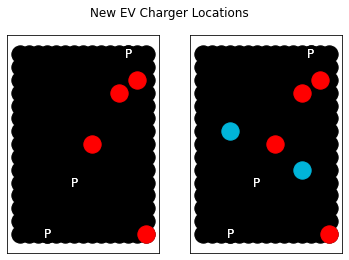

In [14]:
# Create scenario output image
save_output_image(G, pois, charging_stations, new_charging_nodes)

## References 

[1] Pagany, Raphaela, Anna Marquardt, and Roland Zink. "Electric Charging Demand Location Model—A User-and Destination-Based Locating Approach for Electric Vehicle Charging Stations." Sustainability 11.8 (2019): 2301. https://doi.org/10.3390/su11082301